In [1]:
MAX_TIME = 1
INIT_SIZE = 5
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '12-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'12-torch_bartz09_1min_5init_2023-05-13_23-42-59'

# Chapter 12: Sequential Parameter Optimization
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython               0.0.70
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.torch.traintest import evaluate_cv, evaluate_hold_out
from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.1
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load Data Cifar10 Data

In [8]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

Our implementation is based on the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`  and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3}
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters


In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [13]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
# fun_control["core_model_hyper_dict"]
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[2, 2])

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [15]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [16]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [17]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   2     |    2    | None                  |
| patience   | int    |     5     |   2     |   10    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [18]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00, 5.e+00]])

In [19]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Loss on hold-out set: 1.5701051031649114
Accuracy on hold-out set: 0.41535
Epoch: 2
Loss on hold-out set: 1.4471237578347325
Accuracy on hold-out set: 0.47615
Epoch: 3
Loss on hold-out set: 1.3675413416221738
Accuracy on hold-out set: 0.5088
Epoch: 4
Loss on hold-out set: 1.2674916851282119
Accuracy on hold-out set: 0.5492
Epoch: 5
Loss on hold-out set: 1.2489421588920058
Accuracy on hold-out set: 0.5662
Epoch: 6
Loss on hold-out set: 1.2402320769526065
Accuracy on hold-out set: 0.5709
Epoch: 7
Loss on hold-out set: 1.2017598992653191
Accuracy on hold-out set: 0.58975
Epoch: 8
Loss on hold-out set: 1.2035984927948564
Accuracy on hold-out set: 0.59205
Epoch: 9
Loss on hold-out set: 1.1962277063183486
Accuracy on hold-out set: 0.6025
Epoch: 10
Loss on hold-out set: 1.2155781793324276
Accuracy on hold-out set: 0.6075
Epoch: 11
Loss on hold-out set: 1.2259327669033782
Accuracy on hold-out set: 0.60955
Epoch: 12
Loss on hold-out set: 1.2594879214824644
Accuracy on hold-out set: 0.6

### 4 Results

In [20]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [21]:
spot_tuner.y

array([1.45173089, 1.28957653, 1.34064925, 1.24374447, 1.45799803,
       1.3737007 ])

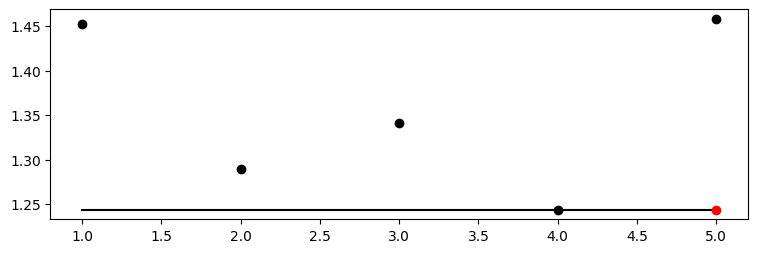

In [22]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [23]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                 tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|-----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                   4.0 | transform_power_2_int |        98.89 | ***     |
| l2         | int    |       5.0 |     2.0 |     9.0 |                   4.0 | transform_power_2_int |         0.00 |         |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.0055413518616154985 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                   2.0 | transform_power_2_int |         0.02 |         |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                   3.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     2.0 |     2.0 |                   2.0 | None             

## Show variable importance

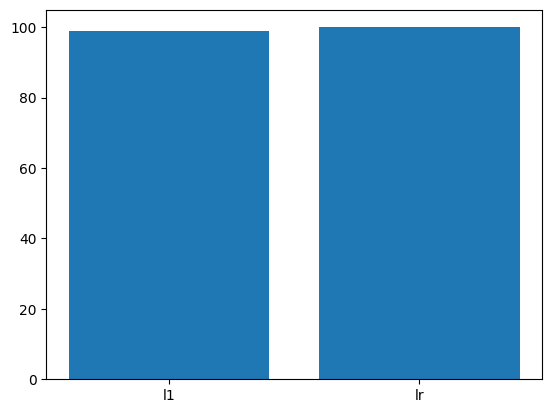

In [24]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [25]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32,
 'l2': 32,
 'lr': 0.001,
 'batch_size': 16,
 'epochs': 8,
 'k_folds': 2,
 'patience': 5}

In [26]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [27]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[4.00000000e+00 4.00000000e+00 5.54135186e-03 2.00000000e+00
  3.00000000e+00 2.00000000e+00 7.00000000e+00]]


In [28]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 16,
  'l2': 16,
  'lr': 0.0055413518616154985,
  'batch_size': 4,
  'epochs': 8,
  'k_folds': 2,
  'patience': 7}]

In [29]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

## Test Set Accuracy

In [30]:
testset = fun_control["test"]
testset.data.shape

(10000, 32, 32, 3)

In [31]:
evaluate_hold_out(model_default, train_dataset = testset, shuffle=False)

Epoch: 1
Loss on hold-out set: 2.2989663610458373
Accuracy on hold-out set: 0.1075
Epoch: 2
Loss on hold-out set: 2.2442206354141234
Accuracy on hold-out set: 0.177
Epoch: 3
Loss on hold-out set: 2.1540287437438965
Accuracy on hold-out set: 0.202
Epoch: 4
Loss on hold-out set: 2.070509069919586
Accuracy on hold-out set: 0.23075
Epoch: 5
Loss on hold-out set: 2.009532246589661
Accuracy on hold-out set: 0.2665
Epoch: 6
Loss on hold-out set: 1.9650993790626525
Accuracy on hold-out set: 0.27475
Epoch: 7
Loss on hold-out set: 1.924751889705658
Accuracy on hold-out set: 0.2915
Epoch: 8
Loss on hold-out set: 1.8871082677841187
Accuracy on hold-out set: 0.3135
Returned to Spot: Validation loss: 1.8871082677841187
----------------------------------------------


(1.8871082677841187, nan)

In [32]:
evaluate_hold_out(model_spot, train_dataset = testset, shuffle=False)

Epoch: 1
Loss on hold-out set: 1.9459445838928222
Accuracy on hold-out set: 0.2655
Epoch: 2
Loss on hold-out set: 1.774938956618309
Accuracy on hold-out set: 0.35125
Epoch: 3
Loss on hold-out set: 1.722619526386261
Accuracy on hold-out set: 0.3895
Epoch: 4
Loss on hold-out set: 1.6496203325092793
Accuracy on hold-out set: 0.407
Epoch: 5
Loss on hold-out set: 1.610793827533722
Accuracy on hold-out set: 0.423
Epoch: 6
Loss on hold-out set: 1.6263530804663897
Accuracy on hold-out set: 0.425
Epoch: 7
Loss on hold-out set: 1.6307733814790846
Accuracy on hold-out set: 0.43875
Epoch: 8
Loss on hold-out set: 1.6513688116520644
Accuracy on hold-out set: 0.4445
Returned to Spot: Validation loss: 1.6513688116520644
----------------------------------------------


(1.6513688116520644, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

Final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [33]:
trainset = fun_control["train"]

In [34]:
evaluate_hold_out(net=model_default, train_dataset=trainset, shuffle=False, test_dataset=testset)

Epoch: 1
Loss on hold-out set: 1.6972870407104492
Accuracy on hold-out set: 0.3801
Epoch: 2
Loss on hold-out set: 1.615728672981262
Accuracy on hold-out set: 0.4069
Epoch: 3
Loss on hold-out set: 1.5593678150177002
Accuracy on hold-out set: 0.4326
Epoch: 4
Loss on hold-out set: 1.5185682277679444
Accuracy on hold-out set: 0.4509
Epoch: 5
Loss on hold-out set: 1.4868259346961976
Accuracy on hold-out set: 0.4638
Epoch: 6
Loss on hold-out set: 1.4574723641395568
Accuracy on hold-out set: 0.4738
Epoch: 7
Loss on hold-out set: 1.4305159115791322
Accuracy on hold-out set: 0.4862
Epoch: 8
Loss on hold-out set: 1.4034419631004333
Accuracy on hold-out set: 0.4983
Returned to Spot: Validation loss: 1.4034419631004333
----------------------------------------------


(1.4034419631004333, nan)

In [35]:
evaluate_hold_out(net=model_spot, train_dataset=trainset, shuffle=False, test_dataset=testset)

Epoch: 1
Batch: 10000. Batch Size: 4. Training Loss (running): 1.451
Loss on hold-out set: 1.2981884287774563
Accuracy on hold-out set: 0.5455
Epoch: 2
Batch: 10000. Batch Size: 4. Training Loss (running): 1.307
Loss on hold-out set: 1.2565766828015448
Accuracy on hold-out set: 0.5679
Epoch: 3
Batch: 10000. Batch Size: 4. Training Loss (running): 1.234
Loss on hold-out set: 1.2548925899244845
Accuracy on hold-out set: 0.5761
Epoch: 4
Batch: 10000. Batch Size: 4. Training Loss (running): 1.189
Loss on hold-out set: 1.2486177013285458
Accuracy on hold-out set: 0.5834
Epoch: 5
Batch: 10000. Batch Size: 4. Training Loss (running): 1.160
Loss on hold-out set: 1.249527706655115
Accuracy on hold-out set: 0.5849
Epoch: 6
Batch: 10000. Batch Size: 4. Training Loss (running): 1.136
Loss on hold-out set: 1.2437392910264433
Accuracy on hold-out set: 0.5907
Epoch: 7
Batch: 10000. Batch Size: 4. Training Loss (running): 1.121
Loss on hold-out set: 1.2555865199358203
Accuracy on hold-out set: 0.5926


(1.2773981384955346, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l1:  98.88655852889605
lr:  100.0


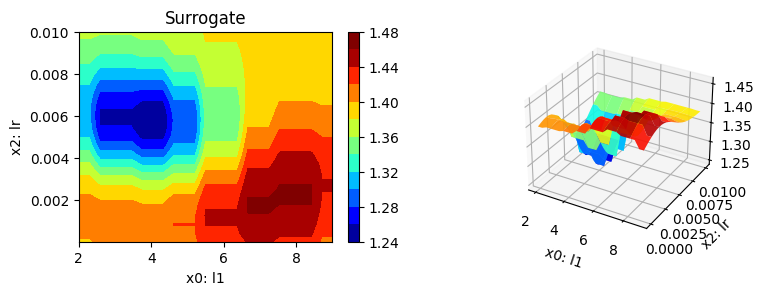

In [36]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [37]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [38]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)